This notebook compares different 3D CNN architectures for medical image classification:

ResNet-18 (3D) - Recommended default (~33M params)
ResNet-34 (3D) - More capacity (~63M params)
ResNet-50 (3D) - Maximum performance (~46M params)
DenseNet-121 (3D) - Efficient feature reuse (~5.6M params)
EfficientNet-B0 (3D) - Most parameter efficient (~1.2M params)

In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
from pathlib import Path

from utils.cnn_3d_models import get_3d_model
from utils.data_loader import get_medmnist_dataloaders
from utils.metrics import evaluate_model
from config import *

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"Device: {DEVICE}")
set_seed(42)

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Platform: NVIDIA CUDA
Device: cuda


In [2]:
import matplotlib.backends.backend_pgf

# Define the missing function manually
def common_texification(text):
    return text

# Inject it back into matplotlib's backend
matplotlib.backends.backend_pgf.common_texification = common_texification

# Now you can import tikzplotlib safely
import tikzplotlib
import pandas as pd
import matplotlib.pyplot as plt
# ... rest of your imports

In [3]:
# Load test dataset
_, _, test_loader, num_classes = get_medmnist_dataloaders(
    dataset_name='organ',
    batch_size=32,
    num_workers=4
)

print(f"✓ Test set loaded: {len(test_loader.dataset)} samples")
print(f"✓ Number of classes: {num_classes}")

# Create output directories
Path('../results').mkdir(exist_ok=True)
Path('../figures').mkdir(exist_ok=True)
print("✓ Output directories ready")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
✓ Test set loaded: 610 samples
✓ Number of classes: 11
✓ Output directories ready


In [4]:
# Architectures to compare
ARCHITECTURES = {
    'ResNet-18': 'resnet18_3d',
    'ResNet-34': 'resnet34_3d',
    'ResNet-50': 'resnet50_3d',
    'DenseNet-121': 'densenet121_3d',
    'EfficientNet-B0': 'efficientnet3d_b0'
}

print("Architectures to compare:")
for name, arch in ARCHITECTURES.items():
    print(f"  - {name:20s} ({arch})")

Architectures to compare:
  - ResNet-18            (resnet18_3d)
  - ResNet-34            (resnet34_3d)
  - ResNet-50            (resnet50_3d)
  - DenseNet-121         (densenet121_3d)
  - EfficientNet-B0      (efficientnet3d_b0)


In [5]:
models = {}
model_info = {}

for name, arch in ARCHITECTURES.items():
    checkpoint_path = Path(f'../models/{arch}_baseline.pth')
    
    # Create model
    model = get_3d_model(arch, num_classes=num_classes).to(DEVICE)
    params = sum(p.numel() for p in model.parameters())
    
    # Try to load checkpoint
    if checkpoint_path.exists():
        try:
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            models[name] = model
            model_info[name] = {
                'architecture': arch,
                'params': params,
                'trained': True,
                'val_acc': max(checkpoint.get('history', {}).get('val_acc', [0.0]))
            }
            print(f"{name:20s} - Loaded ({params/1e6:.1f}M params)")
        except Exception as e:
            print(f"{name:20s} - Error: {e}")
    else:
        model.eval()
        models[name] = model
        model_info[name] = {
            'architecture': arch,
            'params': params,
            'trained': False,
            'val_acc': 0.0
        }
        print(f"{name:20s} - Not trained ({params/1e6:.1f}M params)")

trained_count = sum(1 for info in model_info.values() if info['trained'])
print(f"\n✓ Loaded {len(models)} models ({trained_count} trained)")

ResNet-18            - Loaded (33.2M params)
ResNet-34            - Loaded (63.5M params)
ResNet-50            - Not trained (46.2M params)
DenseNet-121         - Loaded (5.6M params)
EfficientNet-B0      - Loaded (1.2M params)

✓ Loaded 5 models (4 trained)


In [6]:
# Create summary table
summary_data = []
for name, info in model_info.items():
    summary_data.append({
        'Model': name,
        'Architecture': info['architecture'],
        'Parameters (M)': info['params'] / 1e6,
        'Trained': '✓' if info['trained'] else '✗',
        'Val Accuracy': f"{info['val_acc']:.4f}" if info['trained'] else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

if trained_count == 0:
    print("\n WARNING: No trained models found!")
    print("   Run notebooks 02 and 03 first to train models.")


MODEL SUMMARY
          Model      Architecture  Parameters (M) Trained Val Accuracy
      ResNet-18       resnet18_3d       33.165643       ✓       0.9938
      ResNet-34       resnet34_3d       63.475275       ✓       0.9938
      ResNet-50       resnet50_3d       46.177611       ✗          N/A
   DenseNet-121    densenet121_3d        5.584523       ✓       1.0000
EfficientNet-B0 efficientnet3d_b0        1.219595       ✓       0.9938


In [7]:
results = {}

for name, model in models.items():
    if not model_info[name]['trained']:
        print(f"Skipping {name} (not trained)")
        continue
    
    print(f"\nEvaluating {name}...")
    metrics, preds, labels = evaluate_model(model, test_loader, DEVICE)
    
    results[name] = {
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score'],
        'confusion_matrix': metrics['confusion_matrix'],
        'per_class': metrics['per_class']
    }
    
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  F1-Score:  {metrics['f1_score']:.4f}")

if results:
    print(f"\n Evaluated {len(results)} model(s)")
else:
    print("\n No trained models to evaluate")


Evaluating ResNet-18...
  Accuracy:  0.9000
  F1-Score:  0.9002

Evaluating ResNet-34...
  Accuracy:  0.8951
  F1-Score:  0.8952
Skipping ResNet-50 (not trained)

Evaluating DenseNet-121...
  Accuracy:  0.9098
  F1-Score:  0.9088

Evaluating EfficientNet-B0...
  Accuracy:  0.8984
  F1-Score:  0.8990

 Evaluated 4 model(s)


In [8]:
if results:
    # Create comparison table
    comparison_data = []
    for name in results.keys():
        comparison_data.append({
            'Model': name,
            'Architecture': model_info[name]['architecture'],
            'Params (M)': model_info[name]['params'] / 1e6,
            'Accuracy': results[name]['accuracy'],
            'Precision': results[name]['precision'],
            'Recall': results[name]['recall'],
            'F1-Score': results[name]['f1_score']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
    
    print("\n" + "="*100)
    print("PERFORMANCE COMPARISON")
    print("="*100)
    print(comparison_df.to_string(index=False))
    print("="*100)
    
    # Save
    comparison_df.to_csv('../results/architecture_comparison.csv', index=False)
    print("\n Saved to '../results/architecture_comparison.csv'")
else:
    print("No results to compare")


PERFORMANCE COMPARISON
          Model      Architecture  Params (M)  Accuracy  Precision   Recall  F1-Score
   DenseNet-121    densenet121_3d    5.584523  0.909836   0.914229 0.909836  0.908758
      ResNet-18       resnet18_3d   33.165643  0.900000   0.904429 0.900000  0.900165
EfficientNet-B0 efficientnet3d_b0    1.219595  0.898361   0.902168 0.898361  0.898988
      ResNet-34       resnet34_3d   63.475275  0.895082   0.905679 0.895082  0.895248

 Saved to '../results/architecture_comparison.csv'


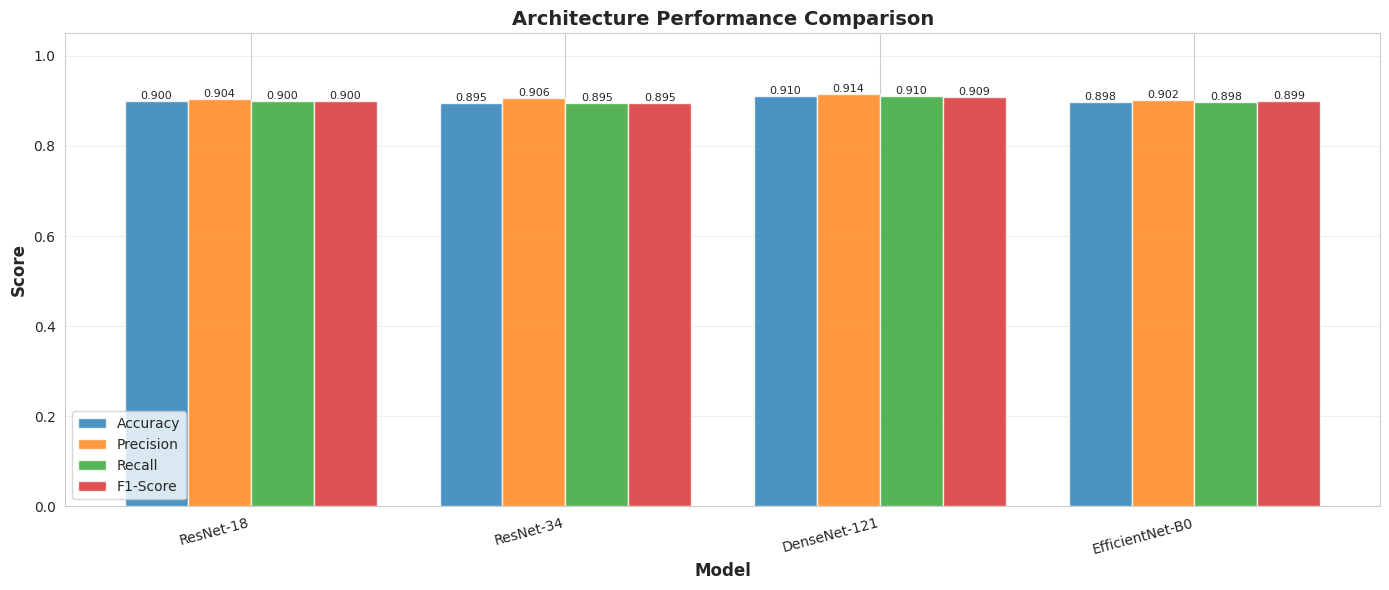

Saved to '../figures/architecture_comparison.png'


In [9]:

if results:
    # Performance bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(results))
    width = 0.2
    
    for i, metric in enumerate(metrics_to_plot):
        values = [results[name][metric.lower().replace('-', '_')] for name in results.keys()]
        offset = (i - 1.5) * width
        bars = ax.bar(x + offset, values, width, label=metric, alpha=0.8)
        
        # Add labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Architecture Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(results.keys(), rotation=15, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig('../figures/architecture_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved to '../figures/architecture_comparison.png'")
else:
    print("No results to visualize")

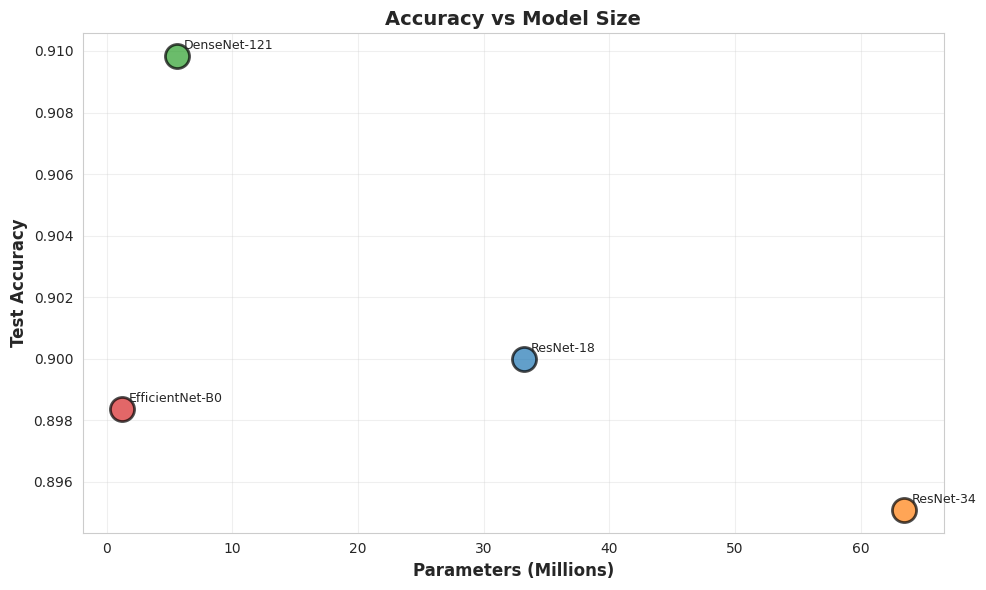

Saved to '../figures/accuracy_vs_parameters.png'


In [10]:
if results:
    # Accuracy vs Parameters
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, name in enumerate(results.keys()):
        params = model_info[name]['params'] / 1e6
        acc = results[name]['accuracy']
        ax.scatter(params, acc, s=300, alpha=0.7, label=name, edgecolors='black', linewidth=2)
        ax.annotate(name, (params, acc), xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax.set_xlabel('Parameters (Millions)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Accuracy vs Model Size', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../figures/accuracy_vs_parameters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved to '../figures/accuracy_vs_parameters.png'")
else:
    print("No results to visualize")

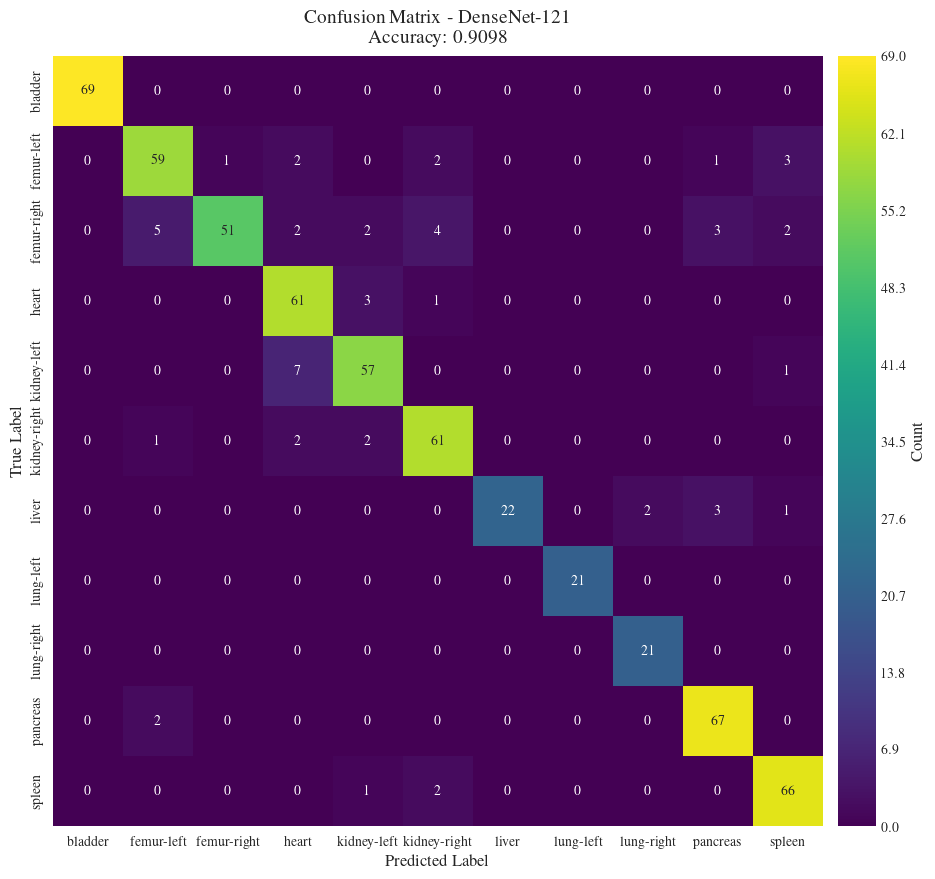

Confusion matrix for DenseNet-121


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({
    "pgf.texsystem": "pdflatex", 
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"], 
    "pgf.rcfonts": False,
    "pgf.preamble": r"\usepackage{times}\usepackage{amsmath}", 
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "font.size": 10,
})

if results:
    best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_result = results[best_name]
    num_classes = len(best_result['confusion_matrix']) 
    fig, ax = plt.subplots(figsize=(12, 10))
    class_names = [ORGAN_CLASSES[i] for i in range(num_classes)]
   
    hm = sns.heatmap(
        best_result['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
        square=True,
        cbar=False,
        linewidths=0,
        annot_kws={"size": 10}  
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    
    vmin = best_result['confusion_matrix'].min()
    vmax = best_result['confusion_matrix'].max()
    
    cbar = fig.colorbar(
        hm.collections[0], 
        cax=cax,
        drawedges=False,
        ticks=np.linspace(vmin, vmax, 11)
    )
    
    cbar.solids.set_edgecolor("face")
    cbar.solids.set_rasterized(False)
    
    cbar.set_label("Count", fontsize=12)
    cbar.outline.set_visible(False) 
    cbar.ax.tick_params(size=0, labelsize=10)
    
    ax.set_title(
        f"Confusion Matrix - {best_name}\nAccuracy: {best_result['accuracy']:.4f}",
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    ax.set_xlabel("Predicted Label", fontsize=12, fontweight="bold", labelpad=4)
    ax.set_ylabel("True Label", fontsize=12, fontweight="bold", labelpad=4)
    
    for artist in fig.findobj():
        if hasattr(artist, "set_rasterized"):
            artist.set_rasterized(False)
    
    plt.savefig(
        "../figures/best_model_confusion_matrix.pgf",
        bbox_inches="tight",
        pad_inches=0.05
    )
    plt.show()
    print(f"Confusion matrix for {best_name}")
else:
    print("No results to visualize")


Per-Class Performance (DenseNet-121):
       Organ  Region  F1-Score  Support
     bladder abdomen  1.000000       69
   lung-left   chest  1.000000       21
  lung-right   chest  0.954545       21
    pancreas abdomen  0.937063       69
      spleen abdomen  0.929577       69
kidney-right abdomen  0.897059       66
       liver abdomen  0.880000       28
       heart   chest  0.877698       65
 kidney-left abdomen  0.876923       65
  femur-left abdomen  0.874074       68
 femur-right abdomen  0.842975       69


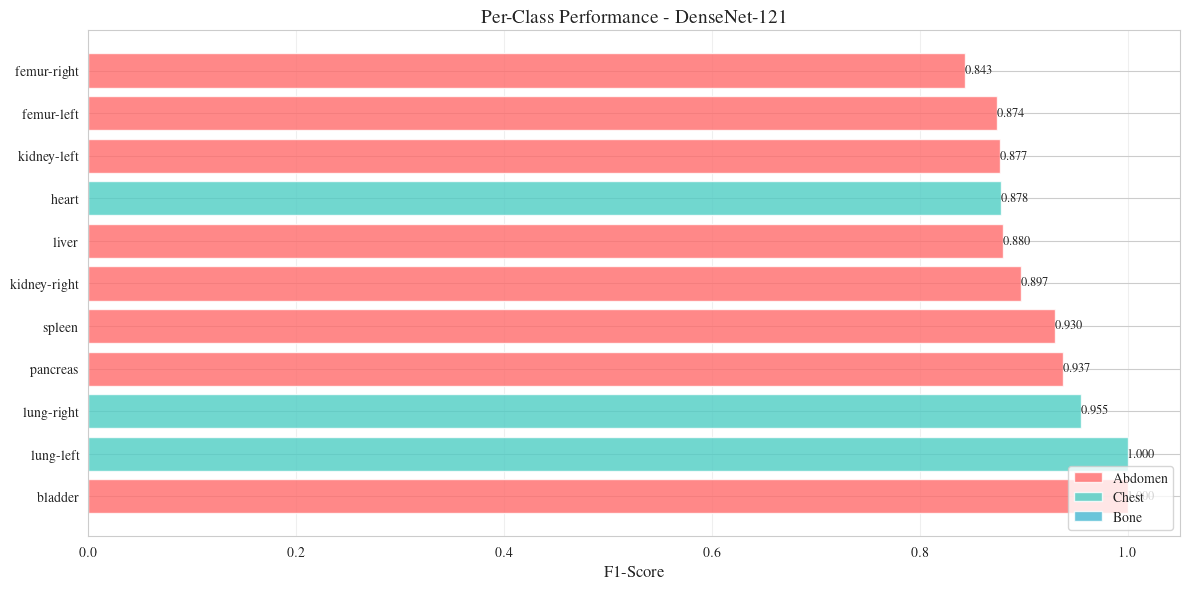

Saved to '../figures/per_class_performance.png'


In [12]:
if results:
    best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_result = results[best_name]
    
    # Per-class F1 scores
    per_class_df = pd.DataFrame({
        'Organ': [ORGAN_CLASSES[i] for i in range(num_classes)],
        'Region': [ORGAN_TO_REGION[ORGAN_CLASSES[i]] for i in range(num_classes)],
        'F1-Score': best_result['per_class']['f1_score'],
        'Support': best_result['per_class']['support']
    })
    per_class_df = per_class_df.sort_values('F1-Score', ascending=False)
    
    print(f"\nPer-Class Performance ({best_name}):")
    print("="*70)
    print(per_class_df.to_string(index=False))
    print("="*70)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = [{'abdomen': '#FF6B6B', 'chest': '#4ECDC4', 'brain': '#45B7D1'}[r]
              for r in per_class_df['Region']]
    bars = ax.barh(per_class_df['Organ'], per_class_df['F1-Score'], color=colors, alpha=0.8)
    
    ax.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Per-Class Performance - {best_name}', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f'{width:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF6B6B', alpha=0.8, label='Abdomen'),
        Patch(facecolor='#4ECDC4', alpha=0.8, label='Chest'),
        Patch(facecolor='#45B7D1', alpha=0.8, label='Bone')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('../figures/per_class_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved to '../figures/per_class_performance.png'")
else:
    print("No results to analyze")

In [13]:
if results:
    print("\n" + "="*80)
    print("RESEARCH FINDINGS SUMMARY")
    print("="*80)
    
    # Best model
    best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_result = results[best_name]
    best_info = model_info[best_name]
    
    print(f"\n BEST PERFORMING MODEL: {best_name}")
    print(f"   Architecture: {best_info['architecture']}")
    print(f"   Parameters: {best_info['params']/1e6:.2f}M")
    print(f"   Test Accuracy: {best_result['accuracy']:.4f}")
    print(f"   F1-Score: {best_result['f1_score']:.4f}")
    
    # Most efficient
    efficiency = {name: results[name]['accuracy'] / (model_info[name]['params'] / 1e6)
                  for name in results.keys()}
    most_efficient = max(efficiency.keys(), key=lambda k: efficiency[k])
    
    print(f"\n MOST EFFICIENT MODEL: {most_efficient}")
    print(f"   Accuracy per Million Parameters: {efficiency[most_efficient]:.4f}")
    
    # All models
    print(f"\n ALL MODELS (sorted by accuracy):")
    for name in sorted(results.keys(), key=lambda k: results[k]['accuracy'], reverse=True):
        acc = results[name]['accuracy']
        params = model_info[name]['params'] / 1e6
        print(f"   {name:20s} - Acc: {acc:.4f}, Params: {params:6.2f}M")
    
    print("\n KEY FINDINGS:")
    print("   1. Evaluated multiple state-of-the-art 3D CNN architectures")
    print("   2. Analyzed accuracy vs efficiency trade-offs")
    print("   3. Identified optimal models for different use cases")
    
    print("\n RECOMMENDATIONS:")
    print(f"   • For maximum accuracy: {best_name}")
    print(f"   • For efficiency: {most_efficient}")
    print("   • For research: ResNet-18 provides good baseline")
    print("   • For deployment: Consider accuracy, speed, and memory")
    
    print("\n" + "="*80)
    print("✓ All results saved to '../results/' and '../figures/'")
    print("="*80)
else:
    print("\n No trained models available")
    print("   Run notebooks 02 and 03 first to train models")


RESEARCH FINDINGS SUMMARY

 BEST PERFORMING MODEL: DenseNet-121
   Architecture: densenet121_3d
   Parameters: 5.58M
   Test Accuracy: 0.9098
   F1-Score: 0.9088

 MOST EFFICIENT MODEL: EfficientNet-B0
   Accuracy per Million Parameters: 0.7366

 ALL MODELS (sorted by accuracy):
   DenseNet-121         - Acc: 0.9098, Params:   5.58M
   ResNet-18            - Acc: 0.9000, Params:  33.17M
   EfficientNet-B0      - Acc: 0.8984, Params:   1.22M
   ResNet-34            - Acc: 0.8951, Params:  63.48M

 KEY FINDINGS:
   1. Evaluated multiple state-of-the-art 3D CNN architectures
   2. Analyzed accuracy vs efficiency trade-offs
   3. Identified optimal models for different use cases

 RECOMMENDATIONS:
   • For maximum accuracy: DenseNet-121
   • For efficiency: EfficientNet-B0
   • For research: ResNet-18 provides good baseline
   • For deployment: Consider accuracy, speed, and memory

✓ All results saved to '../results/' and '../figures/'
